## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import os
import contextlib
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
import warnings
from sklearn.model_selection import StratifiedKFold

## Загрузка данных

In [2]:
df_le=pd.read_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_encoding_le.csv")
df_mte=pd.read_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_encoding_mte.csv")
df_le=df_le.drop('Unnamed: 0', axis=1)
df_mte=df_mte.drop('Unnamed: 0', axis=1)
df_mte.sample(5)

,metro_name,time_to_metro,num_rooms,total_area,year_house,kitchen_area,repair,price,floors,num_floor,address,date,coord_width,coord_len,link,distance_to_Kremlin,district,metro_line,metro_distance
406,Римская,13.0,1.027881e+07,8.5,1961.0,0.0,2.299117e+07,4350000.0,8.0,1.0,"Москва, Нижегородская ул., 13А",21,55.738328,37.687713,https://www.avito.ru/moskva/kvartiry/kvartira-...,4.55,3.387433e+07,2.451582e+07,0
25603,Некрасовка,7.5,1.555949e+07,18.0,2022.0,8.0,2.299117e+07,9500000.0,23.0,9.0,"Москва, улица Маресьева, 6к1",121,55.709880,37.936232,https://avito.ru//moskva/kvartiry/1-k._kvartir...,20.41,1.518474e+07,1.812523e+07,8
1476,Ботанический сад,18.0,1.555949e+07,27.0,1700.0,8.0,2.299117e+07,9950000.0,11.0,5.0,"Москва, Берёзовая аллея, 17к1",16,55.850914,37.617536,https://www.avito.ru/moskva/kvartiry/1-k._kvar...,11.06,2.493670e+07,3.042966e+07,4
15098,NaN,15.5,2.651027e+07,26.5,1973.0,3.0,3.579406e+07,9950000.0,9.0,5.0,"Москва, Хабаровская ул., 18к1",131,55.824471,37.826512,https://avito.ru//moskva/kvartiry/3-k._kvartir...,15.31,1.472755e+07,2.497894e+07,6
3092,Цветной бульвар,8.0,1.996163e+07,34.5,1912.0,10.0,5.234562e+07,37500000.0,6.0,2.0,"Москва, Средний Каретный пер., 4",15,55.770542,37.615380,https://www.avito.ru/moskva/kvartiry/2-k._kvar...,2.13,6.647645e+07,2.633074e+07,4


Будем использовать le кодировку, так как мы работает с lightgbm

In [4]:
X, y=df_mte.drop(['metro_name','coord_width', 'coord_len','link','date','address','price'], axis=1), df_le['price']

## Зависимость между числовыми признаками

Определим список числовых переменных. Количество этажей отнесем к числовым, хотя по смыслу этот признак ближе к категориальныму, потому что все-таки категории довольно размыты из-за большого количества этажей, также нет верхнего предела этажей.

In [4]:
num_col=['time_to_metro','total_area','kitchen_area','floors','num_floor', 'distance_to_Kremlin', 'metro_distance']

Таблица корреляции.

In [5]:
X[num_col].corr()

,time_to_metro,total_area,kitchen_area,floors,num_floor,distance_to_Kremlin,metro_distance
time_to_metro,1.000000,0.069971,0.051028,-0.031994,-0.042522,0.105619,0.212336
total_area,0.069971,1.000000,0.606705,0.023827,0.068075,-0.303391,-0.251984
kitchen_area,0.051028,0.606705,1.000000,0.163974,0.169024,-0.202453,-0.152425
floors,-0.031994,0.023827,0.163974,1.000000,0.690344,-0.052494,0.038615
num_floor,-0.042522,0.068075,0.169024,0.690344,1.000000,-0.041262,0.017784
distance_to_Kremlin,0.105619,-0.303391,-0.202453,-0.052494,-0.041262,1.000000,0.606773
metro_distance,0.212336,-0.251984,-0.152425,0.038615,0.017784,0.606773,1.000000


Визуализация

<AxesSubplot:>

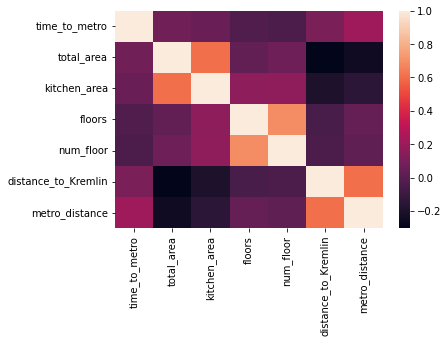

In [6]:
sns.heatmap(X[num_col].corr())

## Работа с признаками

Преобразуем некоторые признаки, между которыми есть прямая зависимость, когда один признак вытекает из другого. И протестируем улучшается ли качество модели после этого преобразования.

Модель на неизмененных данных. Возьмем метрику mape для оценки качества. Не забудем "потюнить" модель.

In [7]:
lgbm_base=LGBMRegressor(bagging_fraction=0.5, random_state=42)
param_grid={'learning_rate':[0.01,0.05,0.1,0.2], 'n_estimators':[1000,2000, 4000], 'lambda_l1':[5,15,30]}
gd=GridSearchCV(lgbm_base, param_grid, cv=5)
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    gd.fit(X, y)
print(f'best_params: {gd.best_params_}')


best_params: {'lambda_l1': 5, 'learning_rate': 0.05, 'n_estimators': 4000}


In [8]:

skf = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
errors=[]
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for tr_ind, val_ind in skf.split(X, y):
            lgbm_base=LGBMRegressor(bagging_fraction=0.5, **gd.best_params_, random_state=42)
            lgbm_base.fit(X.loc[tr_ind,:], y.loc[tr_ind])
            errors.append(mape(y.loc[val_ind],lgbm_base.predict(X.loc[val_ind,:])))
print(f'MAPE for base dataset: {np.mean(errors)}')

MAPE for base dataset: 0.15107854151951636


Площадь кухни. Попробуем взять отношение площади кухни к общей площади. Также не забудем потюнить модель на новых данных.

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    X_k=X.copy()
    y_k=y.copy()
    X_k['kitchen_area']=X_k['kitchen_area']/X_k['total_area']

In [10]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
errors_k=[]
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for tr_ind, val_ind in skf.split(X_k, y_k):
            lgbm_k=LGBMRegressor(bagging_fraction=0.5, **gd.best_params_, random_state=42)
            lgbm_k.fit(X_k.loc[tr_ind,:], y_k.loc[tr_ind])
            errors_k.append(mape(y_k.loc[val_ind],lgbm_k.predict(X_k.loc[val_ind,:])))
print(f'MAPE for k dataset: {np.mean(errors_k)}')

MAPE for k dataset: 0.1518842458520088


Не будем применять это изменение признака.

Количество этажей. Возьмем отношения этажа к количеству этажей и заменим этим признаком признак номера этажа.

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    X_f=X.copy()
    y_f=y.copy()
    X_f['num_floor']=X_f['num_floor']/X_f['floors']

In [12]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
errors_f=[]
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for tr_ind, val_ind in skf.split(X_f, y_f):
            lgbm_f=LGBMRegressor(bagging_fraction=0.5, **gd.best_params_, random_state=42)
            lgbm_f.fit(X_f.loc[tr_ind,:], y_f.loc[tr_ind])
            errors_f.append(mape(y_f.loc[val_ind],lgbm_f.predict(X_f.loc[val_ind,:])))
print(f'MAPE for f dataset: {np.mean(errors_f)}')

MAPE for f dataset: 0.15136536869616685


Не будем применять это изменение признака.

Дальность метро от центральной станции и дистанция до Кремля. Возьмем разность между ними.

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    X_m=X.copy()
    y_m=y.copy()
    X_m['metro_distance']=X_m['distance_to_Kremlin']-X_m['metro_distance']

In [14]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
errors_m=[]
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for tr_ind, val_ind in skf.split(X_m, y_m):
            lgbm_m=LGBMRegressor(bagging_fraction=0.5, **gd.best_params_, random_state=42)
            lgbm_m.fit(X_m.loc[tr_ind,:], y_m.loc[tr_ind])
            errors_m.append(mape(y_m.loc[val_ind],lgbm_m.predict(X_m.loc[val_ind,:])))
print(f'MAPE for f dataset: {np.mean(errors_m)}')

MAPE for f dataset: 0.14958280690743714


Оставим и этот признак. Примем, что на mte кодировки также улучшается/уменьшается качество в зависимости от изменения признака.

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    df_le['metro_distance']=df_le['distance_to_Kremlin']-df_le['metro_distance']
    df_mte['metro_distance']=df_mte['distance_to_Kremlin']-df_mte['metro_distance']

<AxesSubplot:>

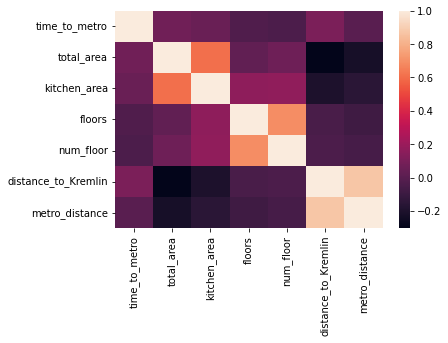

In [16]:
sns.heatmap(df_mte[num_col].corr())

## Взаимодействия признаков.

Мы имеем такое количество признаков:

In [17]:
X.shape[1]

12

In [18]:
X.columns

Index(['time_to_metro', 'num_rooms', 'total_area', 'year_house',
       'kitchen_area', 'repair', 'floors', 'num_floor', 'distance_to_Kremlin',
       'district', 'metro_line', 'metro_distance'],
      dtype='object')

Если брать всевозможные взаимодействия, то получим 12! признаков, что много. Тогда будем руководствоваться логикой. Ничего страшного, если добавим лишний признак, мы потом отберем эти признаки.

Взаимодействие времени до метро и района.

In [6]:
df_le['distr*time']=df_le['district']*df_le['time_to_metro']
df_mte['distr*time']=df_mte['district']*df_mte['time_to_metro']

Взаимодействие времени до метро и расстояния до Кремля.

In [7]:
df_le['Kre*time']=df_le['distance_to_Kremlin']*df_le['time_to_metro']
df_mte['Kre*time']=df_mte['distance_to_Kremlin']*df_mte['time_to_metro']

Взаимодействие общей площади и расстояния до Кремля.

In [8]:
df_le['Kre*area']=df_le['distance_to_Kremlin']*df_le['total_area']
df_mte['Kre*area']=df_mte['distance_to_Kremlin']*df_mte['total_area']

Взаимодействие общей площади и года постройки дома.

In [9]:
df_le['year*area']=df_le['year_house']*df_le['total_area']
df_mte['year*area']=df_mte['year_house']*df_mte['total_area']

Взаимодействие ремонта и года постройки дома.

In [10]:
df_le['year*repair']=df_le['year_house']*df_le['repair']
df_mte['year*repair']=df_mte['year_house']*df_mte['repair']

Взаимодействие количества этажей и года постройки

In [11]:
df_le['year*floors']=df_le['year_house']*df_le['floors']
df_mte['year*floors']=df_mte['year_house']*df_mte['floors']

Взаимодействие общей площади и количества комнат. Отношение общей площади к колиечтсву комнат+1

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  
    df_le['area/num+1']=df_le['total_area']/(df_le['num_rooms']+np.array([1]*df_le.shape[0]))
    df_mte['area/num+1']=df_mte['total_area']/(df_mte['num_rooms'])

## Итоговый датафрейм

In [13]:
df_le.head()

,metro_name,time_to_metro,num_rooms,total_area,year_house,kitchen_area,repair,price,floors,num_floor,...,district,metro_line,metro_distance,distr*time,Kre*time,Kre*area,year*area,year*repair,year*floors,area/num+1
0,Ясенево,8.0,0,26.0,1700.0,0.0,1,3174900.0,16.0,16.0,...,147,5,5.62,1176.0,140.96,458.12,44200.0,1700.0,27200.0,26.0
1,Улица академика Янгеля,31.0,0,10.0,1973.0,0.0,3,2500000.0,12.0,1.0,...,12,10,8.76,372.0,550.56,177.60,19730.0,5919.0,23676.0,10.0
2,Братиславская,25.5,0,14.5,1700.0,0.0,2,5700000.0,26.0,9.0,...,64,7,4.96,1632.0,304.98,173.42,24650.0,3400.0,44200.0,14.5
3,Панфиловская,8.0,0,8.0,1960.0,0.0,0,4900000.0,1.0,1.0,...,140,1,3.59,1120.0,76.72,76.72,15680.0,0.0,1960.0,8.0
4,Рассказовка,31.0,0,20.0,2012.0,0.0,2,3290000.0,3.0,2.0,...,0,12,10.62,0.0,670.22,432.40,40240.0,4024.0,6036.0,20.0


In [14]:
df_le.columns

Index(['metro_name', 'time_to_metro', 'num_rooms', 'total_area', 'year_house',
       'kitchen_area', 'repair', 'price', 'floors', 'num_floor', 'address',
       'date', 'coord_width', 'coord_len', 'link', 'distance_to_Kremlin',
       'district', 'metro_line', 'metro_distance', 'distr*time', 'Kre*time',
       'Kre*area', 'year*area', 'year*repair', 'year*floors', 'area/num+1'],
      dtype='object')

## Сохранение данных

In [15]:
df_le.to_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_feat_eng_le.csv")
df_mte.to_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_feat_eng_mte.csv")